# &#x1F4DD; REPORT

## &#x0031;&#xFE0F;&#x20E3; Coded OFDM Waveform used for 5G NR PUCCH Format 3 Transmission

### &#x0031;&#xFE0F;&#x20E3;.&#x0031;&#xFE0F;&#x20E3; Channel Coding and Rate Matching

* Generate Code Sequence `C` with Reed-Muller Block Code  

#### matlab code location
[`matlab/lab4.m`](matlab/lab4.m)

&#x1F4DC; Matlab Source Code 

```matlab
%M=[0xFFFFFFFF, 0x4BA5A933, 0x7D910E5A, 0x6D26339C, 0x71C7C3E0,0x7E0FFC00, 0x731D8E64, 0x6B44F5B0, 0x7DC218EC, 0x4DA1B746, 0x42F0FFFF]''
M = [4294967295,   1269147955,   2106658394,   1831220124,   1908917216,   2114976768,   1931316836, 1799681456,   2109872364,   1302443846,   1123090431];

% K=11 bit, S=14 symbols
C11_3gpp=zeros(2048,14*12);
cw_QPSK = zeros(16,1);
cw = zeros(32,1);
for C=0:2047, % C is in the input c-sequence, C=[c0 c1 c2 ... c(K-1)]
%  a
  D=mod(C,2)*M(1); % D is the d-sequence, D=[d0 d1 d2 ... d31];
  for n=2:11,
    D = bitxor(D,(mod(floor(C*(2^(1-n))),2)*M(n)));
  end
  for n=0:2:31 % This is pi/2-BPSK
    bit0=(1-(2*mod(floor(D/(2^n)),2)));
    bit1=(1-(2*mod(floor(D/(2^(n+1))),2)));
    cw(1+n) = bit0;
    cw(2+n) = sqrt(-1)*bit1; % to use normal BPSK, remove the pi/2 rotation
    cw_QPSK(1+(n/2)) = (bit0 + sqrt(-1)*bit1)/sqrt(2);
  end
  idx=0;
  for symb=0:13,
    for re=0:11,
      if (symb==3 | symb==10)
         C11_3gpp(1+C,1+(symb*12)+(0:11)) = ones(1,12); 
         C11_3gpp_QPSK(1+C,1+(symb*12)+(0:11)) = ones(1,12); 
         symb=symb+1;
      end
%      fprintf("symb %d,re %d\n",symb,re);
      C11_3gpp(1+C,1+(symb*12)+re) = cw(1+rem(idx,32)); % rate-matching of the cw-sequence
      C11_3gpp_QPSK(1+C,1+(symb*12)+re) = cw_QPSK(1+rem(idx,16)); % rate-matching of the cw-sequence
      idx=idx+1;
    end
   end
end

% C is the code sequence to be generated
C=77;
c0_t=[];
c0_t_QPSK=[];
for symb=0:13,
% extract OFDM symbols "symb" from coded sequence and do the DFT-precoding (SC-FDMA in the lecture slides)
  if (symb==3) 
    symb=4;
  end
  if (symb==10)
    symb=11;
  end
  c0_f = fft(C11_3gpp(1+C,1+(symb*12) + (0:11)));
  c0_f_QPSK = fft(C11_3gpp_QPSK(1+C,1+(symb*12) + (0:11)));
  c0_t = [c0_t ifft(c0_f,2048)];
  c0_t_QPSK = [c0_t_QPSK ifft(c0_f_QPSK,2048)];
end


```

### &#x1F4CA; Plotting

&#x1F5D2; Plotting the block code with Re{C0} and Im{C0} in time-domain

```matlab
figure(1)
subplot(211)
plot(real(c0_t));
subplot(212)
plot(imag(c0_t));
```

![figure](images/lab4-fig1.png)

Plot the Constellation Diagram

### In MATLAB:

The below `plot` function is used to create a 2D line plot, combined with `'.'`, it  generates a scatter plot. 
`axis('square')` makes the plot square in aspect ratio.

### Purpose and Use:

Such a plot is crucial in communications for visualizing the constellation of digitally modulated signals, where each point represents a possible symbol in the modulation scheme. In QPSK, for example, each point corresponds to a unique combination of phase and amplitude that encodes two bits of information. The `axis('square')` command is particularly useful here to ensure the plot accurately reflects the geometry of the signal constellation, where the relative positioning and spacing of points are meaningful.

* Plot π/2-BPSK constellation

```matlab
figure(2)
plot(real(c0_t),imag(c0_t),'.')
axis('square') 
```

![figure](images/lab4-fig2.png)

* Plot QPSK constellation in Time-Domain

```matlab
figure(3)
plot(real(c0_t_QPSK),imag(c0_t_QPSK),'.')
axis('square')
```

![figure](images/lab4-fig3.png)

#### Receiver Code attempt

```matlab
% receiver

SNRdB = 3;
SNR=10^(.1*SNRdB);
% H = get_tdl(61.44e6,30e3,1,300e9,"tdlc");
R = sqrt(SNR) * fft(C11_3gpp(1+C,:)) + randn(1,168) + sqrt(-1)*randn(1,168);

nc_corr = abs(R * C11_3gpp');
```

---

## Attempt: Julia Transpiling of the Matlab Source Code (not working)

In [1]:
# M=[0xFFFFFFFF, 0x4BA5A933, 0x7D910E5A, 0x6D26339C, 0x71C7C3E0, 0x7E0FFC00, 0x731D8E64, 0x6B44F5B0, 0x7DC218EC, 0x4DA1B746, 0x42F0FFFF]
M = [4294967295, 1269147955, 2106658394, 1831220124, 1908917216, 2114976768, 1931316836, 1799681456, 2109872364, 1302443846, 1123090431]

# K=11 bit, S=14 symbols
C11_3gpp = zeros(Complex{Float64}, 2048, 14 * 12)
cw_QPSK = zeros(Complex{Float64}, 16)
cw = zeros(Complex{Float64}, 32);

In [2]:
function generate_d_sequence(C,M)
    D = mod(C, 2) * M[1]

    for n in 2:11
        D = xor(D, Int(mod(floor(C * 2.0^(1-n)), 2) * M[n]))
    end
    return D
end

generate_d_sequence (generic function with 1 method)

In [3]:
D = 0
for C in 0:2047
    D = generate_d_sequence(C,M)
end
println(" D =", D) # 3.2537e+09 

 D =3253698411


In [4]:
function generate_cw_sequence(D)
    cw_QPSK = zeros(ComplexF64, 16, 1)
    cw = zeros(ComplexF64, 32, 1)

    idx = 0
    for n = 0:2:31
        bit0 = 1 - 2 * Int(mod(floor(D / 2.0^n), 2))
        bit1 = 1 - 2 * Int(mod(floor(D / 2.0^(n+1)), 2))
        cw[1 + n] = bit0
        cw[2 + n] = sqrt(Complex(-1))*bit1  # to use normal BPSK, remove the pi/2 rotation
        cw_QPSK[1 + div(n, 2)] = (Float64(bit0) + im * Float64(bit1)) / sqrt(2)
    end

    return cw, cw_QPSK
end

generate_cw_sequence (generic function with 1 method)

In [5]:
cw, cw_QPSK = generate_cw_sequence(D)

println("CW Sequence: ", cw)
println("CW QPSK Sequence: ", cw_QPSK)
@show length(cw), length(cw_QPSK);

CW Sequence: ComplexF64[-1.0 + 0.0im; -0.0 - 1.0im; 1.0 + 0.0im; -0.0 - 1.0im; 1.0 + 0.0im; -0.0 - 1.0im; -1.0 + 0.0im; 0.0 + 1.0im; -1.0 + 0.0im; -0.0 - 1.0im; -1.0 + 0.0im; -0.0 - 1.0im; -1.0 + 0.0im; -0.0 - 1.0im; -1.0 + 0.0im; 0.0 + 1.0im; -1.0 + 0.0im; -0.0 - 1.0im; -1.0 + 0.0im; -0.0 - 1.0im; 1.0 + 0.0im; -0.0 - 1.0im; -1.0 + 0.0im; -0.0 - 1.0im; -1.0 + 0.0im; 0.0 + 1.0im; 1.0 + 0.0im; 0.0 + 1.0im; 1.0 + 0.0im; 0.0 + 1.0im; -1.0 + 0.0im; -0.0 - 1.0im;;]
CW QPSK Sequence: ComplexF64[-0.7071067811865475 - 0.7071067811865475im; 0.7071067811865475 - 0.7071067811865475im; 0.7071067811865475 - 0.7071067811865475im; -0.7071067811865475 + 0.7071067811865475im; -0.7071067811865475 - 0.7071067811865475im; -0.7071067811865475 - 0.7071067811865475im; -0.7071067811865475 - 0.7071067811865475im; -0.7071067811865475 + 0.7071067811865475im; -0.7071067811865475 - 0.7071067811865475im; -0.7071067811865475 - 0.7071067811865475im; 0.7071067811865475 - 0.7071067811865475im; -0.7071067811865475 - 0.70

In [6]:
function rate_matching(C, cw, cw_QPSK)
    C11_3gpp = zeros(Complex{Float64}, 2048, 14 * 12)
    C11_3gpp_QPSK = zeros(Complex{Float64}, 2048, 14 * 12)

    idx = 0
    # for symb in 0:13
    #     for re in 0:11
    #         if symb == 3 || symb == 10
    #             C11_3gpp[1 + C, 1 + (symb * 12) .+ (0:11)] .= ones(12)  # Adjusted broadcasting
    #             C11_3gpp_QPSK[1 + C, 1 + (symb * 12) .+ (0:11)] .= ones(12)  # Adjusted broadcasting
    #             symb += 1
    #         end
    #         # println("symb $symb, re $re")
    #         C11_3gpp[1 + C, 1 + (symb * 12) + re] = cw[1 + rem(idx, 32)]  # rate-matching of the cw-sequence
    #         x1 = 1 + C
    #         x2 = 1 + (symb * 12) + re;
    #         x3 = cw[1 + rem(idx, 32)]
    #         # println("1 + C $x1, x2 $x2, x3 $x3")
    #         C11_3gpp_QPSK[1 + C, 1 + (symb * 12) + re] = cw_QPSK[1 + rem(idx, 16)]  # rate-matching of the cw-sequence
    #         idx += 1
    #     end
    # end
    for symb in 0:13
        for re in 0:11
            if symb == 3 || symb == 10
                C11_3gpp[1+C, 1+(symb*12).+(1:12)] .= 1 # Using broadcasting for assignment to a slice
                C11_3gpp_QPSK[1+C, 1+(symb*12).+(1:12)] .= 1 # Same here
                symb += 1 # This line will not affect the loop variable in Julia
            end
            # The fprintf equivalent in Julia is println or @printf, but it's commented out here as in the original code
            # println("symb $symb, re $re")
            C11_3gpp[1+C, 1+(symb*12)+re] = cw[1+rem(idx,32)] # Accessing elements and using remainder function
            C11_3gpp_QPSK[1+C, 1+(symb*12)+re] = cw_QPSK[1+rem(idx,16)] # Same here
            idx += 1
        end
    end
    return C11_3gpp, C11_3gpp_QPSK
end

rate_matching (generic function with 1 method)

In [7]:
# C is the code sequence to be generated
C=77;
c0_t = zeros(Complex{Float64}, 2048, 14 * 12)
c0_t_QPSK = zeros(Complex{Float64}, 2048, 14 * 12)

C11_3gpp, C11_3gpp_QPSK = rate_matching(C, cw, cw_QPSK)
@show C11_3gpp[78,1:5], C11_3gpp_QPSK[78,1:5], size(C11_3gpp), size(C11_3gpp_QPSK)

(C11_3gpp[78, 1:5], C11_3gpp_QPSK[78, 1:5], size(C11_3gpp), size(C11_3gpp_QPSK)) = (ComplexF64[-1.0 + 0.0im, -0.0 - 1.0im, 1.0 + 0.0im, -0.0 - 1.0im, 1.0 + 0.0im], ComplexF64[-0.7071067811865475 - 0.7071067811865475im, 0.7071067811865475 - 0.7071067811865475im, 0.7071067811865475 - 0.7071067811865475im, -0.7071067811865475 + 0.7071067811865475im, -0.7071067811865475 - 0.7071067811865475im], (2048, 168), (2048, 168))


(ComplexF64[-1.0 + 0.0im, -0.0 - 1.0im, 1.0 + 0.0im, -0.0 - 1.0im, 1.0 + 0.0im], ComplexF64[-0.7071067811865475 - 0.7071067811865475im, 0.7071067811865475 - 0.7071067811865475im, 0.7071067811865475 - 0.7071067811865475im, -0.7071067811865475 + 0.7071067811865475im, -0.7071067811865475 - 0.7071067811865475im], (2048, 168), (2048, 168))

In [8]:
using FFTW

In [9]:
function generate_c0_t(C, C11_3gpp, C11_3gpp_QPSK)
    c0_t = []
    c0_t_QPSK = []

    for symb in 0:13
        if symb == 3 || symb == 10
            continue
        end
        
        # Perform FFT on the extracted symbols with corrected indexing using broadcasting
        x = C11_3gpp[1+C, collect((symb*12).+(1:12))]
        c0_f = fft(x); @show size(c0_f), 1+C, (symb*12).+(1:12), x
        c0_f_QPSK = fft(C11_3gpp_QPSK[1+C, (symb*12).+(1:12)])
        
        # Assuming c0_t and c0_t_QPSK are initialized to collect arrays/vectors
        # Concatenate using vcat or similar functions if necessary
        c0_t = vcat(c0_t, [transpose.(ifft(c0_f,1))])
        # push!( c0_t )
        # push!(c0_t, real(ifft(c0_f)))
        c0_t_QPSK = vcat(c0_t_QPSK, [transpose.(ifft(c0_f_QPSK))])
        # push!(c0_t_QPSK, real(ifft(c0_f_QPSK)))
    end

    # Reshape arrays if needed
    # c0_t = hcat(c0_t...)
    # c0_t_QPSK = hcat(c0_t_QPSK...)

    return c0_t, c0_t_QPSK
end


generate_c0_t (generic function with 1 method)

In [10]:
c0_t, c0_t_QPSK = generate_c0_t(C, C11_3gpp, C11_3gpp_QPSK);
@show length(c0_t), length(c0_t_QPSK)

(size(c0_f), 1 + C, symb * 12 .+ (1:12), x) = ((12,), 78, 1:12, ComplexF64[-1.0 + 0.0im, -0.0 - 1.0im, 1.0 + 0.0im, -0.0 - 1.0im, 1.0 + 0.0im, -0.0 - 1.0im, -1.0 + 0.0im, 0.0 + 1.0im, -1.0 + 0.0im, -0.0 - 1.0im, -1.0 + 0.0im, -0.0 - 1.0im])
(size(c0_f), 1 + C, symb * 12 .+ (1:12), x) = ((12,), 78, 13:24, ComplexF64[-1.0 + 0.0im, -0.0 - 1.0im, -1.0 + 0.0im, 0.0 + 1.0im, -1.0 + 0.0im, -0.0 - 1.0im, -1.0 + 0.0im, -0.0 - 1.0im, 1.0 + 0.0im, -0.0 - 1.0im, -1.0 + 0.0im, -0.0 - 1.0im])
(size(c0_f), 1 + C, symb * 12 .+ (1:12), x) = ((12,), 78, 25:36, ComplexF64[-1.0 + 0.0im, 0.0 + 1.0im, 1.0 + 0.0im, 0.0 + 1.0im, 1.0 + 0.0im, 0.0 + 1.0im, -1.0 + 0.0im, -0.0 - 1.0im, -1.0 + 0.0im, -0.0 - 1.0im, 1.0 + 0.0im, -0.0 - 1.0im])
(size(c0_f), 1 + C, symb * 12 .+ (1:12), x) = ((12,), 78, 49:60, ComplexF64[-1.0 + 0.0im, -0.0 - 1.0im, -1.0 + 0.0im, -0.0 - 1.0im, 1.0 + 0.0im, -0.0 - 1.0im, -1.0 + 0.0im, -0.0 - 1.0im, -1.0 + 0.0im, 0.0 + 1.0im, 1.0 + 0.0im, 0.0 + 1.0im])
(size(c0_f), 1 + C, symb * 12 .+ (1:

(12, 12)

In [11]:
using Plots

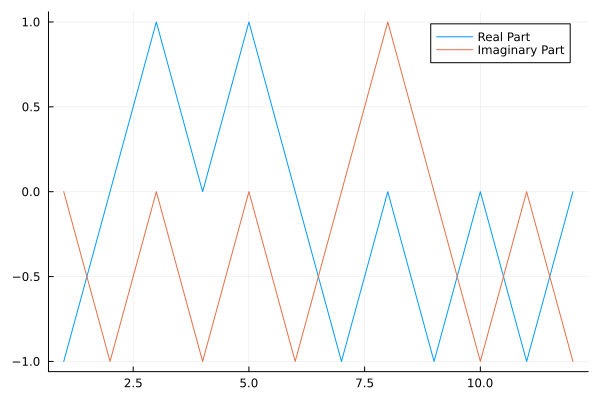

In [12]:
# Figure 1
plot(real(c0_t[1,:]), label="Real Part"
    # , xlims= (0, 30000), ylims = (-0.001, 0.001)
)
plot!(imag(c0_t[1,:]), label="Imaginary Part"
    # , xlims= (0, 30000), ylims = (-0.001, 0.001)
)

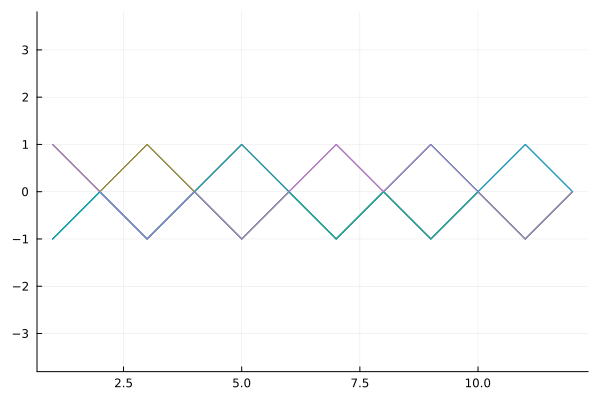

In [13]:
# Figure 2
plot(real(c0_t)
    # , seriestype=:scatter
    , label=:none
    , aspect_ratio=:equal
)

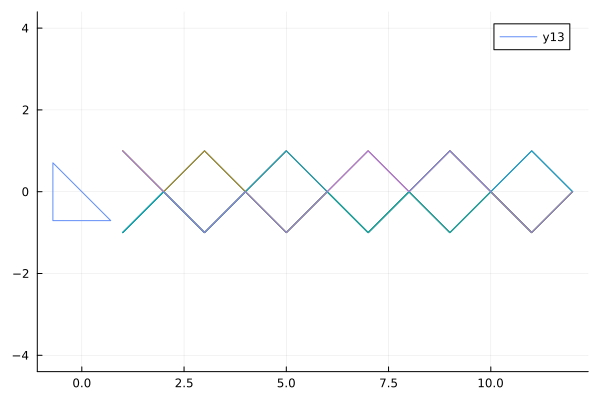

In [14]:
# Figure 3
plot!(real(c0_t_QPSK[1, :]), imag(c0_t_QPSK[1, :])
    # , seriestype=:scatter, label="", aspect_ratio=:equal
)